In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from experiments.mandel_runscript_2 import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0.2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]

flow = [4]
mech = [2,3]

J = model.bmat[mech + flow]
J.plot_max()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


AttributeError: module 'porepy' has no attribute 'utils'

In [2]:
import petsc4py

petsc4py.init()
from petsc4py import PETSc
from mat_utils import make_сlear_petsc_options

options = {
    'ksp_pc_side': 'right',
    'ksp_rtol': 1e-10,
    'ksp_type': 'fgmres',
    'pc_type': 'fieldsplit',
    'pc_fieldsplit_type': 'schur',
    'pc_fieldsplit_schur_precondition': 'selfp',
    'pc_fieldsplit_schur_fact_type': 'upper',
    'fieldsplit_mech_ksp_type': 'preonly',
    'fieldsplit_mech_pc_type': 'hypre',
    'fieldsplit_mech_pc_hypre_type': 'boomeramg',
    'fieldsplit_flow_ksp_type': 'preonly',
    'fieldsplit_flow_pc_type': 'hypre',
    'fieldsplit_flow_pc_hypre_type': 'boomeramg',
    'ksp_monitor': None,
}
subsolver_options = make_сlear_petsc_options()
for k, v in options.items():
    subsolver_options[k] = v 

petsc_ksp = PETSc.KSP().create()
petsc_pc = petsc_ksp.pc
petsc_mat = PETSc.Mat().createAIJ(
    size=J.shape,
    csr=(J.mat.indptr, J.mat.indices, J.mat.data),
    bsize=1,
)

rhs_local = J.project_rhs_to_local(rhs)

petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
# petsc_rhs.set(1.0)
petsc_x0.set(0.0)

dofs_flow = np.concatenate([J.local_dofs_row[x] for i in flow for x in J.groups_to_blocks_row[i]], dtype=np.int32)
dofs_mech = np.concatenate([J.local_dofs_row[x] for i in mech for x in J.groups_to_blocks_row[i]], dtype=np.int32)
isflow = PETSc.IS().createGeneral(dofs_flow)
ismech = PETSc.IS().createGeneral(dofs_mech)
ismech.setBlockSize(model.nd)

petsc_ksp.setOperators(petsc_mat)
petsc_ksp.setFromOptions()
petsc_pc.setFieldSplitIS(('mech', ismech), ('flow', isflow))
petsc_ksp.setUp()
petsc_pc.setUp()

petsc_ksp.setConvergenceHistory()
petsc_ksp.view()

KSP Object: 1 MPI process
  type: fgmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization UPPER
    Preconditioner for the Schur complement formed from Sp, an assembled approximation to S, which uses A00's diagonal's inverse
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_mech_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using DEFAULT norm type for convergence 

In [3]:
petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 2.824711505695e-01 
  1 KSP Residual norm 2.062946011947e-02 
  2 KSP Residual norm 4.354629454608e-03 
  3 KSP Residual norm 2.582692742298e-03 
  4 KSP Residual norm 2.004247035859e-03 
  5 KSP Residual norm 1.494246063709e-03 
  6 KSP Residual norm 8.238255974783e-04 
  7 KSP Residual norm 3.533801237083e-04 
  8 KSP Residual norm 1.333657534332e-04 
  9 KSP Residual norm 7.533241859888e-05 
 10 KSP Residual norm 4.791411588605e-05 
 11 KSP Residual norm 4.010365325213e-05 
 12 KSP Residual norm 2.627828349193e-05 
 13 KSP Residual norm 1.350569939719e-05 
 14 KSP Residual norm 1.024397741429e-05 
 15 KSP Residual norm 4.868511630597e-06 
 16 KSP Residual norm 2.198426816406e-06 
 17 KSP Residual norm 1.090798839258e-06 
 18 KSP Residual norm 2.881554807107e-07 
 19 KSP Residual norm 1.095686583779e-07 
 20 KSP Residual norm 7.985402846103e-08 
 21 KSP Residual norm 4.057340120683e-08 
 22 KSP Residual norm 7.284181843690e-09 
 23 KSP Residual norm 1.7924608165

2

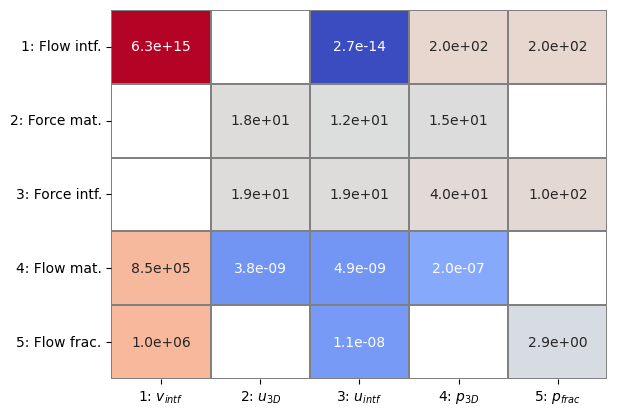

In [4]:
intf = [1]
mech = [2,3]
flow = [4,5]

J = model.bmat[intf + mech + flow]
J.plot_max()

In [5]:
import petsc4py

petsc4py.init()
from petsc4py import PETSc
from mat_utils import make_сlear_petsc_options

options = {
    'ksp_pc_side': 'right',
    'ksp_rtol': 1e-7,
    'ksp_max_it': 120,
    'ksp_type': 'fgmres',
    'pc_type': 'fieldsplit',
    'pc_fieldsplit_type': 'schur',
    'pc_fieldsplit_schur_precondition': 'selfp',
    'fieldsplit_intf_ksp_type': 'preonly',
    'fieldsplit_intf_pc_type': 'ilu',
    # 
    'fieldsplit_mechflow_ksp_type': 'preonly',
    'fieldsplit_mechflow_pc_type': 'fieldsplit',
    'fieldsplit_mechflow_pc_fieldsplit_type': 'schur',
    'fieldsplit_mechflow_pc_fieldsplit_schur_precondition': 'selfp',
    # # 
    # 'fieldsplit_mechflow_fieldsplit_mech_pc_type': 'lu',
    # 'fieldsplit_mechflow_fieldsplit_mech_ksp_type': 'gmres',
    'fieldsplit_mechflow_fieldsplit_mech_ksp_type': 'preonly',
    # 'fieldsplit_mechflow_fieldsplit_mech_pc_type': 'gamg',
    'fieldsplit_mechflow_fieldsplit_mech_pc_type': 'hypre',
    'fieldsplit_mechflow_fieldsplit_mech_pc_hypre_type': 'boomeramg',
    # 
    'fieldsplit_mechflow_fieldsplit_flow_ksp_type': 'preonly',
    # 'fieldsplit_mechflow_fieldsplit_flow_pc_type': 'lu',
    # 'fieldsplit_mechflow_fieldsplit_flow_ksp_type': 'gmres',
    'fieldsplit_mechflow_fieldsplit_flow_pc_type': 'hypre',
    'fieldsplit_mechflow_fieldsplit_flow_pc_hypre_type': 'boomeramg',
    'ksp_monitor': None,
}
subsolver_options = make_сlear_petsc_options()
for k, v in options.items():
    subsolver_options[k] = v 

petsc_ksp = PETSc.KSP().create()
petsc_pc = petsc_ksp.pc
petsc_mat = PETSc.Mat().createAIJ(
    size=J.shape,
    csr=(J.mat.indptr, J.mat.indices, J.mat.data),
    bsize=1,
)

rhs_local = J.project_rhs_to_local(rhs)

petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
petsc_x0.set(0.0)

dofs_intf = np.concatenate([J.local_dofs_row[x] for i in intf for x in J.groups_to_blocks_row[i]], dtype=np.int32)
dofs_mechflow = np.concatenate([J.local_dofs_row[x] for i in mech + flow for x in J.groups_to_blocks_row[i]], dtype=np.int32)
isintf = PETSc.IS().createGeneral(dofs_intf)
ismechflow = PETSc.IS().createGeneral(dofs_mechflow)


S = J[mech + flow]
dofs_flow = np.concatenate([S.local_dofs_row[x] for i in flow for x in S.groups_to_blocks_row[i]], dtype=np.int32)
dofs_mech = np.concatenate([S.local_dofs_row[x] for i in mech for x in S.groups_to_blocks_row[i]], dtype=np.int32)
isflow = PETSc.IS().createGeneral(dofs_flow)
ismech = PETSc.IS().createGeneral(dofs_mech)
ismech.setBlockSize(model.nd)

petsc_ksp.setOperators(petsc_mat)
petsc_ksp.setFromOptions()
petsc_pc.setFieldSplitIS(("intf", isintf), ('mechflow', ismechflow))
petsc_ksp.setUp()
petsc_pc.setUp()

subpc = petsc_pc.getFieldSplitSubKSP()[1].getPC()
subpc.setFieldSplitIS(("mech", ismech), ('flow', isflow))
subpc.setUp()

petsc_ksp.setConvergenceHistory()
petsc_ksp.view()

KSP Object: 1 MPI process
  type: fgmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-07, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization FULL
    Preconditioner for the Schur complement formed from Sp, an assembled approximation to S, which uses A00's diagonal's inverse
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_intf_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using DEFAULT norm type for convergence tes

In [6]:
petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 2.824711505695e-01 
  1 KSP Residual norm 1.232829432960e-01 
  2 KSP Residual norm 1.041772002248e-02 
  3 KSP Residual norm 1.828886038899e-03 
  4 KSP Residual norm 6.246421351341e-04 
  5 KSP Residual norm 2.873550388960e-04 
  6 KSP Residual norm 1.873599248083e-04 
  7 KSP Residual norm 1.256097148506e-04 
  8 KSP Residual norm 9.237407903953e-05 
  9 KSP Residual norm 6.014408452297e-05 
 10 KSP Residual norm 3.761898144475e-05 
 11 KSP Residual norm 2.926265617746e-05 
 12 KSP Residual norm 2.097084646848e-05 
 13 KSP Residual norm 1.294500777946e-05 
 14 KSP Residual norm 5.894619723272e-06 
 15 KSP Residual norm 1.761923262477e-06 
 16 KSP Residual norm 1.154347724782e-06 
 17 KSP Residual norm 5.744835497587e-07 
 18 KSP Residual norm 2.869112383454e-07 
 19 KSP Residual norm 1.581499922687e-07 
 20 KSP Residual norm 5.373417083668e-08 
 21 KSP Residual norm 1.672811690886e-08 


2

In [87]:
from full_petsc_solver import PetscFieldSplitScheme, build_petsc_solver
from fixed_stress import make_fs_analytical
from mat_utils import csr_to_petsc


J = model.bmat[[0, 1, 2, 3, 4, 5]]
Qr = model.Qright(contact_group=0, u_intf_group=3)[[0, 1, 2, 3, 4, 5]]
JQ = J.empty_container()
JQ.mat = J.mat @ Qr.mat

petsc_ksp, options = build_petsc_solver(
    bmat=JQ,
    scheme=PetscFieldSplitScheme(
        groups=[0],
        block_size=model.nd,
        fieldsplit_options={
            "pc_fieldsplit_schur_precondition": "full",
        },
        subsolver_options={
            "pc_type": "ilu",
        },
        complement=PetscFieldSplitScheme(
            groups=[1],
            fieldsplit_options={},
            subsolver_options={
                "pc_type": "ilu",
            },
            complement=PetscFieldSplitScheme(
                groups=[2, 3],
                subsolver_options={
                    "ksp_type": "preonly",
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                    "pc_hypre_boomeramg_stong_threshold": 0.7,
                },
                block_size=model.nd,
                complement=PetscFieldSplitScheme(
                    groups=[4, 5],
                    subsolver_options={
                        "pc_type": "hypre",
                        "pc_hypre_type": "boomeramg",
                        "pc_hypre_boomeramg_stong_threshold": 0.7,
                    },
                ),
            ),
        ),
    ),
)
options

{'ksp_monitor': None,
 'ksp_type': 'gmres',
 'ksp_pc_side': 'right',
 'ksp_rtol': 1e-10,
 'ksp_max_it': 120,
 'pc_type': 'fieldsplit',
 'pc_fieldsplit_type': 'schur',
 'pc_fieldsplit_schur_precondition': 'full',
 'fieldsplit_0_ksp_type': 'preonly',
 'fieldsplit_0_pc_type': 'ilu',
 'fieldsplit_1-2-3-4-5_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5_pc_type': 'fieldsplit',
 'fieldsplit_1-2-3-4-5_pc_fieldsplit_type': 'schur',
 'fieldsplit_1-2-3-4-5_pc_fieldsplit_schur_precondition': 'selfp',
 'fieldsplit_1-2-3-4-5_fieldsplit_1_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5_fieldsplit_1_pc_type': 'ilu',
 'fieldsplit_1-2-3-4-5_fieldsplit_2-3-4-5_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5_fieldsplit_2-3-4-5_pc_type': 'fieldsplit',
 'fieldsplit_1-2-3-4-5_fieldsplit_2-3-4-5_pc_fieldsplit_type': 'schur',
 'fieldsplit_1-2-3-4-5_fieldsplit_2-3-4-5_pc_fieldsplit_schur_precondition': 'selfp',
 'fieldsplit_1-2-3-4-5_fieldsplit_2-3-4-5_fieldsplit_2-3_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5_fields

In [88]:
petsc_ksp.view()

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization FULL
    Preconditioner for the Schur complement formed from the exact Schur complement
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using NONE norm type for convergence test
      PC Object: (fieldsplit_0_) 1 MPI process
    

In [89]:
rhs_local = JQ.project_rhs_to_local(rhs)

petsc_mat = petsc_ksp.getOperators()[0]
petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
petsc_x0.set(0.0)

petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 2.824717101097e-01 
  1 KSP Residual norm 9.816371448203e-03 
  2 KSP Residual norm 1.524890406823e-03 
  3 KSP Residual norm 4.838724997062e-04 
  4 KSP Residual norm 9.451909537045e-05 
  5 KSP Residual norm 3.205562684384e-05 
  6 KSP Residual norm 9.828698818187e-06 
  7 KSP Residual norm 2.280045266329e-06 
  8 KSP Residual norm 4.125184662232e-07 
  9 KSP Residual norm 9.945035008978e-08 
 10 KSP Residual norm 1.253813433607e-08 
 11 KSP Residual norm 2.757670100900e-09 
 12 KSP Residual norm 2.746111022042e-10 
 13 KSP Residual norm 4.928222652566e-11 
 14 KSP Residual norm 6.935552286683e-12 


2

In [84]:
from mat_utils import csr_to_petsc, inv_block_diag, petsc_to_csr
from full_petsc_solver import PetscFieldSplitScheme, build_petsc_solver


tmp = JQ[[0, 3]]
petsc_ksp, options = build_petsc_solver(
    bmat=tmp[[0, 3]],
    scheme=PetscFieldSplitScheme(
        groups=[0],
        block_size=model.nd,
        fieldsplit_options={
            "pc_fieldsplit_schur_precondition": "full",
        },
        subsolver_options={
            "pc_type": "ilu",
        },
        complement=PetscFieldSplitScheme(
            groups=[3],
            fieldsplit_options={},
            subsolver_options={
                "pc_type": "ilu",
            },
        ),
    ),
)

options

{'ksp_monitor': None,
 'ksp_type': 'gmres',
 'ksp_pc_side': 'right',
 'ksp_rtol': 1e-10,
 'ksp_max_it': 120,
 'pc_type': 'fieldsplit',
 'pc_fieldsplit_type': 'schur',
 'pc_fieldsplit_schur_precondition': 'full',
 'fieldsplit_0_ksp_type': 'preonly',
 'fieldsplit_0_pc_type': 'ilu',
 'fieldsplit_3_ksp_type': 'preonly',
 'fieldsplit_3_pc_type': 'ilu'}

In [85]:
rhs_local = tmp.project_rhs_to_local(rhs)
petsc_mat = petsc_ksp.getOperators()[0]
petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
petsc_x0.set(0.0)

petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 2.565604599723e-01 
  1 KSP Residual norm 5.822082229554e-04 
  2 KSP Residual norm 2.200382521167e-05 
  3 KSP Residual norm 1.358436625500e-06 
  4 KSP Residual norm 4.020299871977e-08 
  5 KSP Residual norm 1.020923814081e-09 
  6 KSP Residual norm 5.915779440624e-11 
  7 KSP Residual norm 2.131645406433e-12 


2